In [1]:
import pandas as pd
import numpy as np
from numpy import asarray
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn import datasets, linear_model
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn_evaluation import plot
from os import getcwd
from os import chdir
from os import environ
import altair as alt
import seaborn as sns
import re
from sklearn.metrics import classification_report, confusion_matrix 

In [2]:
def normalized_data(df, columnname):
    data_series = pd.to_numeric(df[columnname])
    xx = data_series/data_series.mean()
    df[columnname + '_norm'] = xx
    return df

def conv_to_num(df):
    dfn = pd.DataFrame()

    for each in df:
        try: 
            dfn[each] =  pd.to_numeric(df[each])
        except:
            dfn[each] = df[each]
    return dfn

def add_time_dummy(df):
    df['Time'] = np.arange(len(df.index))
    return df

def choose_park(df, fullParkName):
    df = df.loc[df['ParkName'] == fullParkName].copy()
    return df

##lag by 12 to predict same month next year

def add_lag(df, column, num_lag):
    df[column + '_lag'] = df[column].shift(num_lag)
    return df

def to_new_datetime(df, yearcol, monthcol):
    df['Date'] = pd.to_datetime(df[[yearcol, monthcol]].assign(DAY=1))
    return df

def MSE_MAPE(y_true, y_pred):
    MSE = 'MSE: ' + str(mean_squared_error(y_true, y_pred))
    MAPE = 'MAPE: ' + str(mean_absolute_percentage_error(y_true, y_pred))
    r2 = 'R2: ' + str(metrics.r2_score(y_true, y_pred))
    RMSE = 'RMSE: ' + str((mean_squared_error(y_true, y_pred)**.5))
    exp_var = 'Explained Variance: ' + str(explained_variance_score(y_true, y_pred))
    return MSE, MAPE, r2, RMSE, exp_var

def drop_2020_data(df):
    df = df.drop(df[(pd.to_numeric(df['Year'])==2020)].index, inplace = True)
    return df

#clean DF for supervised learning algorithms to drop categorical data, regular values
def columns_for_sup_learn_reg(df):
    reg_df =  df[['RecreationVisits', 'NonRecreationVisits', 'RecreationHours',
       'NonRecreationHours', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays',
       'Google_Searches', 'Time', 'RecreationVisits_lag', 'Google_Searches_lag']]
    return reg_df

#clean DF for supervised learning algorithms to drop categorical data, normalized values
def columns_for_sup_learn_norm(df):
    reg_df =  df[['RecreationVisits_norm', 'NonRecreationVisits', 'RecreationHours',
       'NonRecreationHours', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays',
       'RecreationVisits_norm', 'Time', 'RecreationVisits_norm_lag', 'Google_Searches_norm_lag']]
    return reg_df

def columns_for_sup_learn_lag(df):
    reg_df = df[['RecreationVisits', 'Time', 'RecreationVisits_lag', 'RecreationHours_lag',
           'Google_Searches_lag', 'NonRecreationVisits_lag',
           'ConcessionerLodging_lag', 'ConcessionerCamping_lag', 'TentCampers_lag',
           'RVCampers_lag', 'Backcountry_lag', 'NonRecreationOvernightStays_lag',
           'MiscellaneousOvernightStays_lag']]
    return reg_df


def smooth_column(df, columnName):
    windowSize = 4
    df['smoothed_RV']=df.columnName.rolling(window=windowSize, center = True).mean()
    
def cross_val(model, X, y, folds):
    scores = cross_val_score(model, X, y, cv = folds)
    return scores, scores.mean(), scores.std()


**Read in Park and Google Trends Data**

In [3]:
trendDF=pd.read_csv('assets/NPS_with_trends.csv',dtype=str)
display(len(trendDF))
trendDF =  trendDF[['ParkName', 'UnitCode', 'Region', 'State',
       'Year', 'Month', 'RecreationVisits', 'NonRecreationVisits',
       'RecreationHours', 'NonRecreationHours', 'ConcessionerLodging',
       'ConcessionerCamping', 'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays','Google_Searches']]



12839

In [4]:
display(trendDF.ParkName.unique())

array(['Acadia National Park', 'Arches National Park',
       'Badlands National Park', 'Big Bend National Park',
       'Biscayne National Park',
       'Black Canyon of the Gunnison National Park',
       'Bryce Canyon National Park', 'Canyonlands National Park',
       'Capitol Reef National Park', 'Carlsbad Caverns National Park',
       'Channel Islands National Park', 'Congaree National Park',
       'Crater Lake National Park', 'Cuyahoga Valley National Park',
       'Death Valley National Park', 'Denali National Park',
       'Dry Tortugas National Park', 'Everglades National Park',
       'Gates of the Arctic National Park', 'Gateway Arch National Park',
       'Glacier Bay National Park', 'Glacier National Park',
       'Grand Canyon National Park', 'Grand Teton National Park',
       'Great Basin National Park', 'Great Sand Dunes National Park',
       'Great Smoky Mountains National Park',
       'Guadalupe Mountains National Park', 'Haleakala National Park',
       'Hawaii

**Choose a park. Working with Specific Park Data**

In [5]:
npDF = choose_park(trendDF, 'Yosemite National Park')

**Clean and Manipulate Data**

In [6]:
drop_2020_data(npDF)
add_time_dummy(npDF)
# add_lag(npDF, 'RecreationVisits', 12)
add_lag(npDF, 'Google_Searches', 1)
to_new_datetime(npDF, 'Year', 'Month')
# normalized_data(npDF, 'RecreationVisits')
# normalized_data(npDF, 'Google_Searches')
# add_lag(npDF, 'RecreationVisits_norm', 12)
# add_lag(npDF, 'Google_Searches_norm', 1)

display(npDF.head())

,ParkName,UnitCode,Region,State,Year,Month,RecreationVisits,NonRecreationVisits,RecreationHours,NonRecreationHours,...,ConcessionerCamping,TentCampers,RVCampers,Backcountry,NonRecreationOvernightStays,MiscellaneousOvernightStays,Google_Searches,Time,Google_Searches_lag,Date
12431,Yosemite National Park,YOSE,Pacific West,CA,2005,1,91238,3697,1249400,3697,...,0,677,1776,733,0,0,59,0,NaN,2005-01-01
12432,Yosemite National Park,YOSE,Pacific West,CA,2005,2,103756,2652,1444377,2652,...,0,960,1368,1000,0,0,65,1,59,2005-02-01
12433,Yosemite National Park,YOSE,Pacific West,CA,2005,3,143335,3798,2311805,3798,...,0,2297,4208,1050,0,0,61,2,65,2005-03-01
12434,Yosemite National Park,YOSE,Pacific West,CA,2005,4,195385,5084,3529291,5084,...,0,19505,16120,1092,0,288,75,3,61,2005-04-01
12435,Yosemite National Park,YOSE,Pacific West,CA,2005,5,304552,4606,5326616,4606,...,0,32598,19568,6205,0,1743,100,4,75,2005-05-01


**Add lag to data**

In [7]:
feat_list = ['RecreationVisits', 'NonRecreationVisits', 'RecreationHours', 
    'ConcessionerLodging', 'ConcessionerCamping', 'TentCampers', 'RVCampers', 'Backcountry', 'NonRecreationOvernightStays', 'MiscellaneousOvernightStays',]
for feat in feat_list:
    add_lag(npDF, feat, 12)



**Look at Correlation between variables**

In [8]:
display(npDF.columns)

Index(['ParkName', 'UnitCode', 'Region', 'State', 'Year', 'Month',
       'RecreationVisits', 'NonRecreationVisits', 'RecreationHours',
       'NonRecreationHours', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays',
       'Google_Searches', 'Time', 'Google_Searches_lag', 'Date',
       'RecreationVisits_lag', 'NonRecreationVisits_lag',
       'RecreationHours_lag', 'ConcessionerLodging_lag',
       'ConcessionerCamping_lag', 'TentCampers_lag', 'RVCampers_lag',
       'Backcountry_lag', 'NonRecreationOvernightStays_lag',
       'MiscellaneousOvernightStays_lag'],
      dtype='object')

In [9]:
# regrDF = npDF[['RecreationVisits', 'NonRecreationVisits', 'RecreationHours',
#        'NonRecreationHours', 'ConcessionerLodging',
#        'TentCampers', 'RVCampers', 'Backcountry', 'MiscellaneousOvernightStays',
#        'Google_Searches', 'Time', 'RecreationVisits_lag', 'Google_Searches_lag']].copy()

regrDF = npDF[['RecreationVisits', 'Time', 'RecreationVisits_lag', 'RecreationHours_lag',
       'Google_Searches_lag', 'NonRecreationVisits_lag',
       'ConcessionerLodging_lag', 'ConcessionerCamping_lag', 'TentCampers_lag',
       'RVCampers_lag', 'Backcountry_lag', 'NonRecreationOvernightStays_lag',
       'MiscellaneousOvernightStays_lag']].copy()

In [10]:
for each in regrDF.columns:
    regrDF[each]=regrDF[each].astype(float)

In [11]:
matrix = regrDF.corr()

display(matrix)

,RecreationVisits,Time,RecreationVisits_lag,RecreationHours_lag,Google_Searches_lag,NonRecreationVisits_lag,ConcessionerLodging_lag,ConcessionerCamping_lag,TentCampers_lag,RVCampers_lag,Backcountry_lag,NonRecreationOvernightStays_lag,MiscellaneousOvernightStays_lag
RecreationVisits,1.000000,0.131780,0.942498,0.944716,0.415394,0.917915,0.866279,NaN,0.904093,0.854246,0.842209,NaN,0.815494
Time,0.131780,1.000000,0.177635,0.073592,-0.471431,0.244147,-0.061048,NaN,0.017050,0.141706,0.163139,NaN,0.079694
RecreationVisits_lag,0.942498,0.177635,1.000000,0.973117,0.419437,0.978437,0.866027,NaN,0.925116,0.892498,0.863414,NaN,0.838927
RecreationHours_lag,0.944716,0.073592,0.973117,1.000000,0.479182,0.940820,0.922651,NaN,0.971882,0.899652,0.894142,NaN,0.884852
Google_Searches_lag,0.415394,-0.471431,0.419437,0.479182,1.000000,0.358013,0.529707,NaN,0.470634,0.397694,0.378734,NaN,0.380798
NonRecreationVisits_lag,0.917915,0.244147,0.978437,0.940820,0.358013,1.000000,0.831569,NaN,0.880481,0.865307,0.851017,NaN,0.823515
ConcessionerLodging_lag,0.866279,-0.061048,0.866027,0.922651,0.529707,0.831569,1.000000,NaN,0.861592,0.788472,0.732128,NaN,0.749276
ConcessionerCamping_lag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TentCampers_lag,0.904093,0.017050,0.925116,0.971882,0.470634,0.880481,0.861592,NaN,1.000000,0.839347,0.874305,NaN,0.887208
RVCampers_lag,0.854246,0.141706,0.892498,0.899652,0.397694,0.865307,0.788472,NaN,0.839347,1.000000,0.765978,NaN,0.759357


<AxesSubplot:>

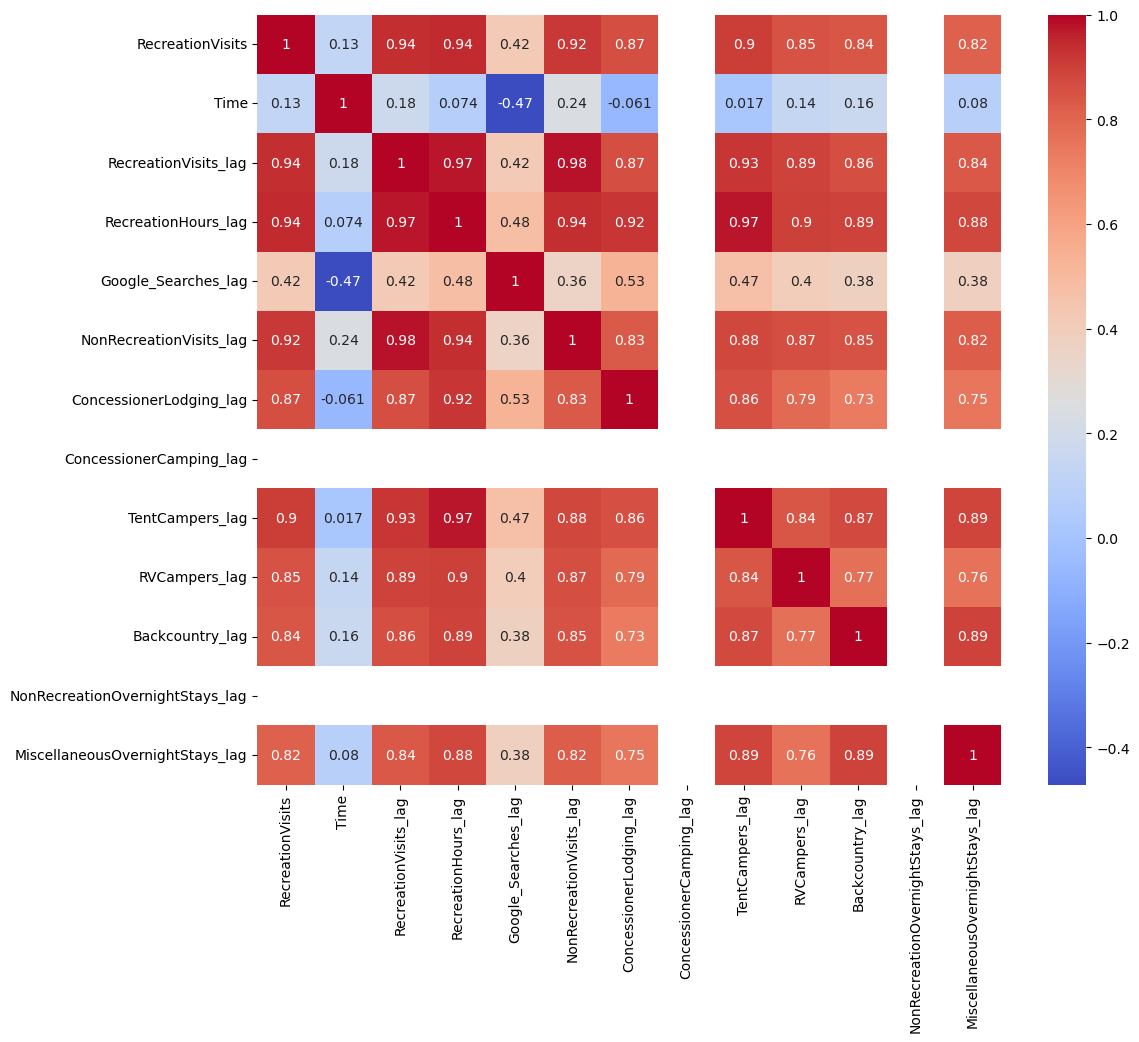

In [12]:
plt.figure(figsize = (12,10))
sns.heatmap(matrix, cmap='coolwarm', annot=True)

**Algorithm Comparison**

In [13]:
# algcompDF = columns_for_sup_learn_reg(npDF).copy()
algcompDF = columns_for_sup_learn_lag(npDF).copy()

# algcompDF['Month'] = npDF['Month']
# algcompDF['Year'] = npDF['Year']
# to_new_datetime(algcompDF, 'Year', 'Month')
# algcompDF = algcompDF.drop(['Year', 'Month'], axis=1)
# display(algcompDF)
# algcompDF = algcompDF.drop(['RecreationHours'], axis=1)
                           
algcompDF.dropna(axis=0, inplace = True)

# all_feat_df = all_feat_df.drop(['RecreationHours', 'NonRecreationOvernightStays','Backcountry', 'ConcessionerCamping', 'NonRecreationHours', 'NonRecreationVisits'  ], axis = 1)
labels = np.array(algcompDF['RecreationVisits'])

# display(all_feat_df.columns)
features = algcompDF.drop('RecreationVisits', axis=1)

feature_list = list(features.columns)

features = np.array(features)

In [14]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

LR: 0.791123 (0.101915)
GB: 0.858076 (0.069831)
RF: 0.895920 (0.053228)
SVR: -0.250679 (0.398875)


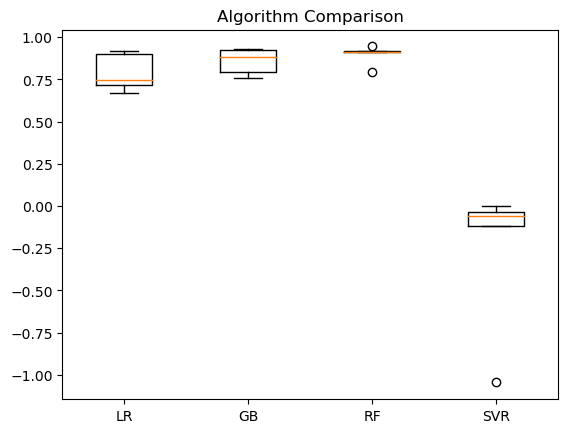

In [15]:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
models = []
models.append(('LR', LinearRegression()))
# models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('GB', GradientBoostingRegressor())) 
models.append(('RF', RandomForestRegressor())) 
models.append(('SVR', SVR(gamma='auto'))) 
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit()
    
    cv_results = cross_val_score(model, train_features, train_labels, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

**Time Plot with Linear Regression Line via Altair**

In [16]:
scatter = alt.Chart(npDF).mark_line(point=True).encode(
    x='Time:Q',
    y= alt.Y('RecreationVisits:Q', axis = alt.Axis(title = 'Recreation Visits'))

)
scatter+scatter.transform_regression('Time', 'RecreationVisits').mark_line(color='red')

alt.LayerChart(...)

**Plot Original Data Against Lag Data with Regression Line via Altair** 
<br>
We can see that there is a correlation between the visits that occurred on a previous month.

In [17]:
scatter = alt.Chart(npDF).mark_line(point=True).encode(
    x= alt.X('RecreationVisits_lag:Q',axis = alt.Axis(title = 'Recreation Visits with Lag')),
    y= alt.Y('RecreationVisits:Q', axis = alt.Axis(title = 'Recreation Visits'))

)
scatter+scatter.transform_regression('RecreationVisits_lag', 'RecreationVisits').mark_line(color='red')

alt.LayerChart(...)

**Linear Regression Sklearn Time vs Recreation Visits**

In [18]:
X = npDF.loc[:, ['Time']]
y = npDF.loc[:, 'RecreationVisits']

reg = LinearRegression()
reg.fit(X,y)

npDF['y_pred'] = pd.Series(reg.predict(X), index=X.index)
# display(zionDF.head())

**Linear Regression Time vs Recreation Visits Scores**

In [19]:
y_true = npDF['RecreationVisits']
y_pred = npDF['y_pred']

MSE_MAPE(y_true, y_pred)

('MSE: 35225074525.1112',
 'MAPE: 0.7930172259475737',
 'R2: 0.017365947768440027',
 'RMSE: 187683.44233072666',
 'Explained Variance: 0.017365947768439915')

**Linear Regression Plot**

In [20]:
pred_scatter = alt.Chart(npDF).mark_circle().encode(
    x='Time:Q',
    y= 'RecreationVisits:Q',

)

pred_line = alt.Chart(npDF).mark_line(color = 'red').encode(
    x='Time:Q',
    y= 'y_pred:Q',
)


pred_scatter + pred_line

alt.LayerChart(...)

**Linear Regression Sklearn Recreation Visits vs Recreation Visits with Lag**

In [21]:
X_lag = npDF.loc[:, ['RecreationVisits_lag']]
y_lag = npDF.loc[:, 'RecreationVisits']
X_lag.dropna(inplace=True)
y_lag,X_lag = y_lag.align(X_lag, join='inner')

reg2 = LinearRegression()
reg2.fit(X_lag, y_lag)

npDF['y_pred_lag'] = pd.Series(reg2.predict(X_lag), index=X_lag.index)


# print(zionDF['y_pred_lag'])
# print(zionDF['RecreationVisits'])

**Cross Validation Scores**

In [22]:
lr_cv = cross_val(reg2, X_lag, y_lag, 10)
print(lr_cv)

(array([0.95302386, 0.98413116, 0.94519681, 0.96451215, 0.98252633,
       0.94863272, 0.89353813, 0.86034997, 0.77171895, 0.47334547]), 0.8776975564832611, 0.14845871211115522)


**Linear Regression Scores for prediction of Recreation visits from Recreation Visits with a lag**

In [23]:
y_pred_lag = np.array(npDF['y_pred_lag'])
y_true_lag = np.array(npDF['RecreationVisits'])



lagnan = ~np.isnan(y_pred_lag)
y_pred_lag = y_pred_lag[lagnan]
y_true_lag = y_true_lag[lagnan]



# y_true_lag = zionDF['RecreationVisits']
# y_pred_lag = zionDF['y_pred_lag']

lr_score = MSE_MAPE(y_true_lag, y_pred_lag)
print(lr_score)



('MSE: 4069765911.6609354', 'MAPE: 0.14092736197160563', 'R2: 0.8883030135076423', 'RMSE: 63794.7169572915', 'Explained Variance: 0.8883030135076423')


**Linear Regression Plot**

In [24]:
pred_scatter_lag = alt.Chart(npDF).mark_circle().encode(
    x='RecreationVisits_lag:Q',
    y= 'RecreationVisits:Q',

)

pred_line_lag = alt.Chart(npDF).mark_line(color = 'red').encode(
    x='RecreationVisits_lag:Q',
    y= 'y_pred_lag:Q',
)


pred_scatter_lag + pred_line_lag

alt.LayerChart(...)

**Graph of Predictions (red) versus true visits (orange)**

In [25]:
line1 = alt.Chart(npDF).mark_line(color='orange').encode(
    x='Time:Q',
    y= 'RecreationVisits:Q',

)

line2 = alt.Chart(npDF).mark_line(color = 'red').encode(
    x='Time:Q',
    y= 'y_pred_lag:Q',
)


line1+line2

alt.LayerChart(...)

**Random Forest Regressor**

In [26]:
npDF = npDF.drop(['y_pred', 'y_pred_lag'], axis=1)

In [27]:
display(npDF.columns)

Index(['ParkName', 'UnitCode', 'Region', 'State', 'Year', 'Month',
       'RecreationVisits', 'NonRecreationVisits', 'RecreationHours',
       'NonRecreationHours', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays',
       'Google_Searches', 'Time', 'Google_Searches_lag', 'Date',
       'RecreationVisits_lag', 'NonRecreationVisits_lag',
       'RecreationHours_lag', 'ConcessionerLodging_lag',
       'ConcessionerCamping_lag', 'TentCampers_lag', 'RVCampers_lag',
       'Backcountry_lag', 'NonRecreationOvernightStays_lag',
       'MiscellaneousOvernightStays_lag'],
      dtype='object')

**First use all features for the Random Forest Regressor**

In [28]:
# all_feat_df = columns_for_sup_learn_reg(npDF).copy()
all_feat_df = columns_for_sup_learn_lag(npDF).copy()
# display(all_feat_df.columns)

all_feat_df.dropna(axis=0, inplace = True)
# all_feat_df = all_feat_df.drop(['RecreationHours', 'NonRecreationOvernightStays','Backcountry', 'ConcessionerCamping', 'NonRecreationHours', 'NonRecreationVisits'  ], axis = 1)
labels = np.array(all_feat_df['RecreationVisits'])

# display(all_feat_df.columns)
features = all_feat_df.drop('RecreationVisits', axis=1)

feature_list_all = list(features.columns)

features = np.array(features)

In [29]:
train_features_all, test_features_all, train_labels_all, test_labels_all = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [30]:
rfr = RandomForestRegressor(n_estimators = 500, random_state = 42)
rfr.fit(train_features_all, train_labels_all)

RandomForestRegressor(n_estimators=500, random_state=42)

**Random Forest Regressor Scores (used all features)**

In [31]:
predictions_all = rfr.predict(test_features_all)

MSE_MAPE(test_labels_all, predictions_all)

('MSE: 2342367501.240286',
 'MAPE: 0.08661367938997128',
 'R2: 0.937453957307087',
 'RMSE: 48398.011335594005',
 'Explained Variance: 0.9381435122930554')

**Cross-Validation for All Features**

In [32]:
scores, mean, stand_d = cross_val(rfr, train_features_all, train_labels_all, 10)
print(scores)
print(mean)
print(stand_d)

[0.9315917  0.76939616 0.9711211  0.96743137 0.92661677 0.86603911
 0.83222041 0.89700522 0.81986207 0.96127834]
0.8942562243997738
0.06631187491997467


Think we may be getting some data leakage due to the high influence of certain features as seen in the feature importance

**Feature Importance for All Features**

In [33]:
important_list = list(rfr.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_all, important_list)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: RecreationVisits_lag Importance: 0.68
Variable: TentCampers_lag      Importance: 0.09
Variable: Backcountry_lag      Importance: 0.09
Variable: RecreationHours_lag  Importance: 0.07
Variable: MiscellaneousOvernightStays_lag Importance: 0.02
Variable: Time                 Importance: 0.01
Variable: Google_Searches_lag  Importance: 0.01
Variable: NonRecreationVisits_lag Importance: 0.01
Variable: ConcessionerLodging_lag Importance: 0.01
Variable: RVCampers_lag        Importance: 0.01
Variable: ConcessionerCamping_lag Importance: 0.0
Variable: NonRecreationOvernightStays_lag Importance: 0.0


In [34]:
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)

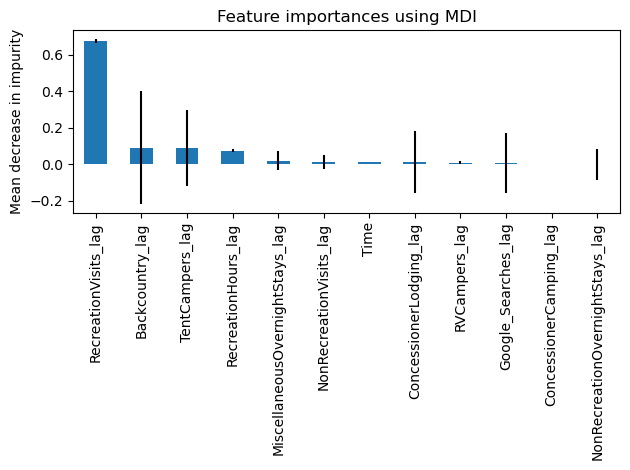

In [35]:
forest_importances = pd.Series(importances, index=feature_list_all)
forest_importances = forest_importances.sort_values(ascending = False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**Edited code to remove RecreationHours and re-test (No longer necessary since we added a lag to all variables)**

In [36]:
# display(all_feat_df)
mod_feat_df = all_feat_df.copy()# 'NonRecreationOvernightStays','Backcountry', 'ConcessionerCamping', 'NonRecreationHours', 'NonRecreationVisits'  ], axis = 1)
labels = np.array(mod_feat_df['RecreationVisits'])

# display(all_feat_df.columns)
features = mod_feat_df.drop('RecreationVisits', axis=1)

feature_list = list(features.columns)

features = np.array(features)

In [37]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [38]:
rfr = RandomForestRegressor(n_estimators = 500, random_state = 42)
rfr.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=500, random_state=42)

In [39]:
important_list = list(rfr.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, important_list)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: RecreationVisits_lag Importance: 0.68
Variable: TentCampers_lag      Importance: 0.09
Variable: Backcountry_lag      Importance: 0.09
Variable: RecreationHours_lag  Importance: 0.07
Variable: MiscellaneousOvernightStays_lag Importance: 0.02
Variable: Time                 Importance: 0.01
Variable: Google_Searches_lag  Importance: 0.01
Variable: NonRecreationVisits_lag Importance: 0.01
Variable: ConcessionerLodging_lag Importance: 0.01
Variable: RVCampers_lag        Importance: 0.01
Variable: ConcessionerCamping_lag Importance: 0.0
Variable: NonRecreationOvernightStays_lag Importance: 0.0


In [40]:
# def important_features(model):
#     important_list = list(model.feature_importances_)

#     feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, important_list)]

#     feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
#     print(feature_importances)
#     # [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
#     return feature_importances

# feature_importances = important_features(rfr)


Much better. Now we're going to drop the scores that are zero (along with RecreationHours)

In [41]:
droplist = [feature[0:] for feature, importance in feature_importances if importance == 0]
print(droplist)

['ConcessionerCamping_lag', 'NonRecreationOvernightStays_lag']


**Remove all features that are zero**

In [42]:
# display(all_feat_df)
# final_feat_df = all_feat_df.drop(['RecreationHours','NonRecreationOvernightStays','NonRecreationVisits', 'NonRecreationHours','Google_Searches', 'Google_Searches_lag'], axis = 1)
final_feat_df = all_feat_df.drop(droplist, axis = 1)

labels = np.array(final_feat_df['RecreationVisits'])

# display(all_feat_df.columns)
features = final_feat_df.drop('RecreationVisits', axis=1)

feature_list = list(features.columns)

features = np.array(features)

In [43]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [44]:
# rfr = RandomForestRegressor(n_estimators = 500, random_state = 42)
rfr = RandomForestRegressor(max_depth = None, max_features= 'sqrt', n_estimators = 100, random_state = 42)
rfr.fit(train_features, train_labels)

RandomForestRegressor(max_features='sqrt', random_state=42)

In [45]:
predictions = rfr.predict(test_features)

In [46]:
rfr_score = MSE_MAPE(test_labels, predictions)
print(rfr_score)

('MSE: 2223345915.018533', 'MAPE: 0.08620937522965297', 'R2: 0.9406320791044831', 'RMSE: 47152.36913473737', 'Explained Variance: 0.94080012638588')


In [47]:
rf_cv = cross_val(rfr, train_features, train_labels, 10)
print(rf_cv)

(array([0.92515281, 0.84274493, 0.9742956 , 0.97575354, 0.94003443,
       0.85524864, 0.81291307, 0.86467284, 0.83225323, 0.95960119]), 0.8982670268519547, 0.05976513820601563)


In [48]:
important_list = list(rfr.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, important_list)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: RecreationVisits_lag Importance: 0.25
Variable: TentCampers_lag      Importance: 0.22
Variable: RecreationHours_lag  Importance: 0.2
Variable: Backcountry_lag      Importance: 0.11
Variable: MiscellaneousOvernightStays_lag Importance: 0.07
Variable: NonRecreationVisits_lag Importance: 0.05
Variable: ConcessionerLodging_lag Importance: 0.05
Variable: RVCampers_lag        Importance: 0.03
Variable: Time                 Importance: 0.01
Variable: Google_Searches_lag  Importance: 0.01


In [49]:
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)

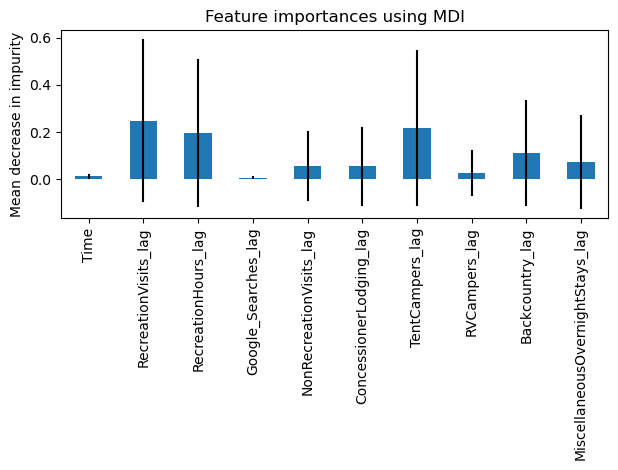

In [50]:
forest_importances = pd.Series(importances, index=feature_list)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**Determining Most Appropriate Parameters**

In [51]:
param_grid = {'n_estimators': [100, 200, 500, 800],  
              'max_depth': [1, 3, 5, None],
              'max_features':['sqrt', 'log2', 1]}  
   
grid = GridSearchCV(rfr, param_grid, refit = True, verbose = 3, n_jobs=-1)

grid_fit= grid.fit(train_features, train_labels)



Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [52]:
print(grid_fit.best_params_)

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}


In [53]:
# print(grid.cv_results_)

<AxesSubplot:title={'center':'Grid search results'}, xlabel='n_estimators', ylabel='Mean score'>

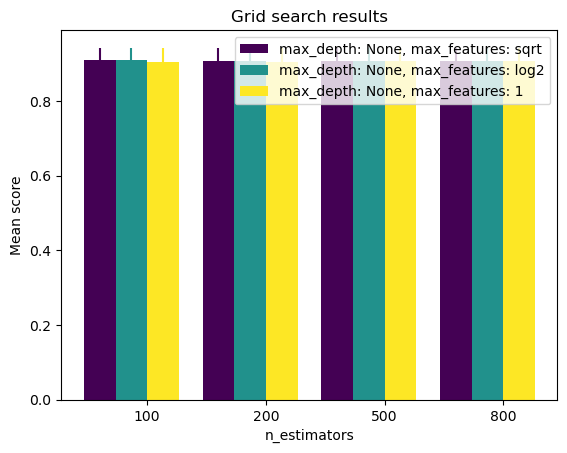

In [54]:
plot.grid_search(grid_fit.cv_results_, change='n_estimators',
                 subset = {'n_estimators': [100, 200, 500, 800],
                           'max_depth': None},
                           # 'max_features':'sqrt'},
                 kind='bar', sort=False)

<AxesSubplot:title={'center':'Grid search results'}, xlabel='n_estimators', ylabel='Mean score'>

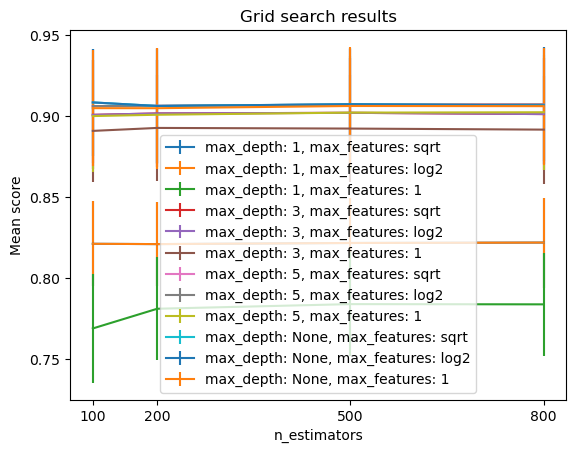

In [55]:
plot.grid_search(grid_fit.cv_results_, change = 'n_estimators', sort=False)

**Gradiant Boosting Regressor**

In [56]:
GB_reg = GradientBoostingRegressor(random_state=42)
GB_reg.fit(train_features, train_labels)

GradientBoostingRegressor(random_state=42)

**Gradiant Boosting Scores**

In [57]:
GB_predictions = GB_reg.predict(test_features)

gb_score = MSE_MAPE(test_labels, GB_predictions)
print(gb_score)

('MSE: 2851115093.187258', 'MAPE: 0.10315507950642523', 'R2: 0.9238693474672633', 'RMSE: 53395.834043371375', 'Explained Variance: 0.9239838460714854')


**Gradient Boosting Cross-Validation**

In [58]:
gb_cv = cross_val(GB_reg, train_features, train_labels, 10)
print(gb_cv)

(array([0.97178953, 0.8280932 , 0.97335192, 0.95241532, 0.90262438,
       0.87394465, 0.81085349, 0.92810733, 0.82214086, 0.97268259]), 0.9036003258965613, 0.06252220876894221)


**Gradient Boosting Feature Importance**

In [59]:
important_list_gb = list(GB_reg.feature_importances_)

feature_importances_gb = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, important_list_gb)]

feature_importances_gb = sorted(feature_importances_gb, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_gb];

Variable: RecreationVisits_lag Importance: 0.66
Variable: TentCampers_lag      Importance: 0.12
Variable: Backcountry_lag      Importance: 0.09
Variable: RecreationHours_lag  Importance: 0.06
Variable: Time                 Importance: 0.02
Variable: NonRecreationVisits_lag Importance: 0.01
Variable: ConcessionerLodging_lag Importance: 0.01
Variable: RVCampers_lag        Importance: 0.01
Variable: MiscellaneousOvernightStays_lag Importance: 0.01
Variable: Google_Searches_lag  Importance: 0.0


In [60]:
importances_gb = GB_reg.feature_importances_
# std_gb = np.std([boost.feature_importances_ for boost in GB_reg.estimators_], axis=0)

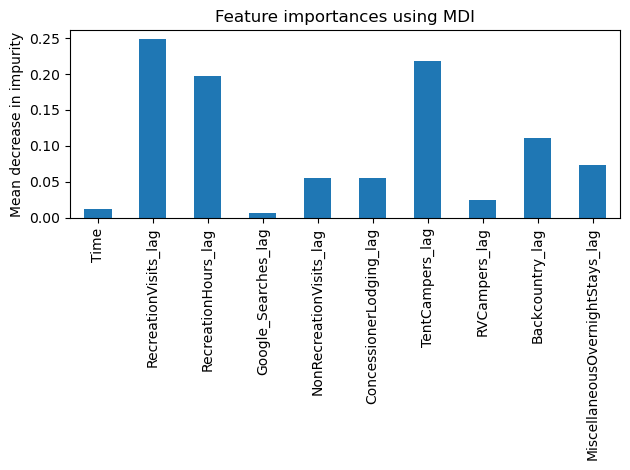

In [61]:
GB_reg_importances = pd.Series(importances_gb, index=feature_list)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**Dataframe of all Model Scores**

In [62]:
scoreList = lr_score, rfr_score, gb_score

crossvalList = lr_cv, rf_cv, gb_cv

cv = []
std = []
for value in crossvalList:
    # print(value)
    cv += [value[1]]
    std += [value[2]]
print(cv)
print(std)
# print(lr_score)
# listList = lr_list, rfr_list, gb_list
fitType = ['Linear Regression', 'Random Forest Regressor', 'Gradiant Boosting Regressor']

scoreDF=pd.DataFrame()
for name, score in zip(fitType, scoreList):
    wordlist = []
    numlist = []
    print(name)

    for word in score:
        word, number = tuple(word.split(': '))
        wordlist += [word]
        numlist += [round(float(number),4)]
    
    scoreDict = dict(zip(wordlist, numlist))
    scoreDict['Model']= name
    scoreDict={k:[v] for k,v in scoreDict.items()}
    scoreDF = pd.concat([scoreDF,pd.DataFrame(scoreDict)])

scoreDF=scoreDF.set_index('Model')

scoreDF['CrossValidation'] = cv
scoreDF['CrossValSTD'] = std
display(scoreDF)
# print(word)
# print(number)
        # range(listList += [word.split()[-1]]
# print(lr_list)
# rfr_score
# gb_score

[0.8776975564832611, 0.8982670268519547, 0.9036003258965613]
[0.14845871211115522, 0.05976513820601563, 0.06252220876894221]
Linear Regression
Random Forest Regressor
Gradiant Boosting Regressor


,MSE,MAPE,R2,RMSE,Explained Variance,CrossValidation,CrossValSTD
Model,,,,,,,
Linear Regression,4.069766e+09,0.1409,0.8883,63794.7170,0.8883,0.877698,0.148459
Random Forest Regressor,2.223346e+09,0.0862,0.9406,47152.3691,0.9408,0.898267,0.059765
Gradiant Boosting Regressor,2.851115e+09,0.1032,0.9239,53395.8340,0.9240,0.903600,0.062522


In [63]:
tot = final_feat_df.RecreationVisits.astype(float)
tot_sum = tot.sum()
print(tot_sum)

58430963.0


In [64]:
scoreDF['RMSE_normalized'] = scoreDF.RMSE.astype(float) / tot_sum

display(scoreDF)

,MSE,MAPE,R2,RMSE,Explained Variance,CrossValidation,CrossValSTD,RMSE_normalized
Model,,,,,,,,
Linear Regression,4.069766e+09,0.1409,0.8883,63794.7170,0.8883,0.877698,0.148459,0.001092
Random Forest Regressor,2.223346e+09,0.0862,0.9406,47152.3691,0.9408,0.898267,0.059765,0.000807
Gradiant Boosting Regressor,2.851115e+09,0.1032,0.9239,53395.8340,0.9240,0.903600,0.062522,0.000914
